In [2]:
import sys
sys.path.append('/home/potzschf/repos/')
from helperToolz.helpsters import *
from helperToolz.dicts_and_lists import INT_TO_MONTH

In [37]:
# set storPath for exported tiffs
storPath = '/data/Aldhani/eoagritwin/et/Sentinel3/LST/LST_values/daily_observations_all/'
LST_path = '/data/Aldhani/eoagritwin/et/Sentinel3/raw_LST/'
VZA_path = '/data/Aldhani/eoagritwin/et/Sentinel3/VZA/monthly_tiff_masks/'
AcqTime_path = ''
AirTemp_path = '/data/Aldhani/eoagritwin/et/Auxiliary/ERA5/tiff/2m_temperature/'

LST_files = sorted(getFilelist('/data/Aldhani/eoagritwin/et/Sentinel3/raw_LST', '.nc'))

year = 2017
# get a subset of files for that year
files = sorted(getFilelist(LST_path, '.nc'))
yearFiles_LST = [file for file in LST_files if int(file.split('/')[-1].split('_')[-1][0:4]) == year]
yearFiles_VZA = getFilelist(f'{VZA_path}{year}/', 'tif')

# create a maks for germany
mask = makeGermanyMaskforNC('/data/Aldhani/eoagritwin/misc/gadm41_DEU_shp/gadm41_DEU_0.shp', yearFiles_LST[0])

In [73]:
# loop over files and export to .tif at Path locations
for i, month in enumerate([f'{i:02d}' for i in range(1,13)]):

    if i == 1:
        break

    file_LST = [yearfile_LST for yearfile_LST in yearFiles_LST if f'{month}.nc' == yearfile_LST.split('-')[-1]][0]
    accDateTimes = getAllDatesS3(file_LST) # possible to take annual subset if entire files list would be passed here
   
    dat_LST = getDataFromNC_LST(file_LST)
    
    # apply the temperature threshold
    dat_LST[dat_LST<273.15] = np.nan

    # apply the VZA threshold
    file_VZA = [yearfile_VZA for yearfile_VZA in yearFiles_VZA if f'{month}.tif' == yearfile_VZA.split('_')[-1]][0]
    dat_VZA = []
    ds = gdal.Open(file_VZA)
    for b in range(ds.RasterCount):
        dat_VZA.append(ds.GetRasterBand(1).ReadAsArray())
    dat_VZA = np.dstack(dat_VZA)

    dat_LST[dat_VZA == 0] = np.nan

    # check air temperature (2m ERA5)
    air_ds = gdal.Open([file for file in getFilelist(f'{AirTemp_path}{year}', '.tif') if INT_TO_MONTH[month] in file][0])
    bnames = []
    [bnames.append(air_ds.GetRasterBand(b+1).GetDescription()) for b in range(air_ds.RasterCount)]
    

In [89]:
bands = []
for accDT in accDateTimes:
    for count, bname in enumerate(bnames):
        if (accDT + np.timedelta64(30, 'm')).astype('datetime64[h]')== pd.Timestamp(bname):
            bands.append(count+1)

In [100]:
air_block = []
for band in bands:
    air_block.append(air_ds.GetRasterBand(band).ReadAsArray())
air_block = np.dstack(air_block)

(array([2.4000e+02, 9.7900e+02, 9.3210e+03, 2.8609e+04, 3.7373e+04,
        3.9411e+04, 3.9451e+04, 3.9453e+04, 3.9421e+04, 3.7655e+04,
        3.0208e+04, 1.9270e+04, 1.3447e+04, 1.1060e+04, 9.0610e+03,
        6.3110e+03, 4.2070e+03, 1.9200e+03, 1.2390e+03, 8.9000e+02,
        5.1000e+02, 2.6500e+02, 1.7600e+02, 8.5000e+01, 2.8000e+01]),
 array([-8.25375366, -7.04976559, -5.84577751, -4.64178944, -3.43780136,
        -2.23381329, -1.02982521,  0.17416286,  1.37815094,  2.58213902,
         3.78612709,  4.99011517,  6.19410324,  7.39809132,  8.60207939,
         9.80606842, 11.01005554, 12.21404266, 13.41803169, 14.62202072,
        15.82600784, 17.02999496, 18.23398399, 19.43797302, 20.64196014,
        21.84594727]),
 <BarContainer object of 25 artists>)

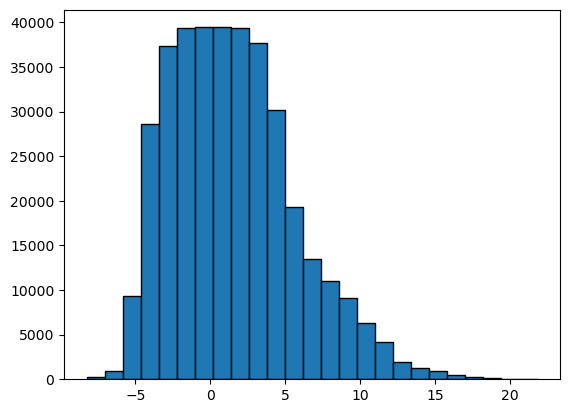

In [106]:
plt.hist(np.unique(dat_LST - air_block),bins=25, edgecolor='black')

In [97]:
for i in range(80):
    print(accDateTimes[i])
    print(air_ds.GetRasterBand(bands[i]).GetDescription())

2017-01-01T09:47:00.000000000
2017-01-01 10:00:00
2017-01-01T18:12:00.000000000
2017-01-01 18:00:00
2017-01-01T19:53:00.000000000
2017-01-01 20:00:00
2017-01-02T09:20:00.000000000
2017-01-02 09:00:00
2017-01-02T19:26:00.000000000
2017-01-02 19:00:00
2017-01-03T08:54:00.000000000
2017-01-03 09:00:00
2017-01-03T10:35:00.000000000
2017-01-03 11:00:00
2017-01-03T19:00:00.000000000
2017-01-03 19:00:00
2017-01-04T10:09:00.000000000
2017-01-04 10:00:00
2017-01-04T18:34:00.000000000
2017-01-04 19:00:00
2017-01-04T20:15:00.000000000
2017-01-04 20:00:00
2017-01-05T09:43:00.000000000
2017-01-05 10:00:00
2017-01-05T18:08:00.000000000
2017-01-05 18:00:00
2017-01-05T19:49:00.000000000
2017-01-05 20:00:00
2017-01-06T09:17:00.000000000
2017-01-06 09:00:00
2017-01-06T19:23:00.000000000
2017-01-06 19:00:00
2017-01-07T08:51:00.000000000
2017-01-07 09:00:00
2017-01-07T10:32:00.000000000
2017-01-07 11:00:00
2017-01-07T18:56:00.000000000
2017-01-07 19:00:00
2017-01-08T10:05:00.000000000
2017-01-08 10:00:00


In [83]:
for accDT in accDateTimes:
    print((accDT + np.timedelta64(30, 'm')).astype('datetime64[h]'))

2017-01-01T10
2017-01-01T18
2017-01-01T20
2017-01-02T09
2017-01-02T19
2017-01-03T09
2017-01-03T11
2017-01-03T19
2017-01-04T10
2017-01-04T19
2017-01-04T20
2017-01-05T10
2017-01-05T18
2017-01-05T20
2017-01-06T09
2017-01-06T19
2017-01-07T09
2017-01-07T11
2017-01-07T19
2017-01-08T10
2017-01-08T19
2017-01-08T20
2017-01-09T10
2017-01-09T18
2017-01-09T20
2017-01-10T09
2017-01-10T19
2017-01-11T09
2017-01-11T10
2017-01-11T19
2017-01-12T10
2017-01-12T18
2017-01-12T20
2017-01-13T10
2017-01-13T20
2017-01-14T09
2017-01-14T11
2017-01-14T19
2017-01-15T09
2017-01-15T10
2017-01-15T19
2017-01-16T10
2017-01-16T18
2017-01-16T20
2017-01-17T10
2017-01-17T20
2017-01-18T09
2017-01-18T11
2017-01-18T19
2017-01-19T09
2017-01-19T10
2017-01-19T19
2017-01-20T10
2017-01-20T18
2017-01-20T20
2017-01-21T09
2017-01-21T20
2017-01-22T09
2017-01-22T11
2017-01-22T19
2017-01-23T19
2017-01-23T20
2017-01-24T10
2017-01-24T18
2017-01-24T20
2017-01-25T09
2017-01-25T20
2017-01-26T09
2017-01-26T11
2017-01-26T19
2017-01-27T09
2017-0

In [86]:
(accDateTimes[0] + np.timedelta64(30, 'm')).astype('datetime64[h]') == bnames[11]

False

In [87]:
bnames

['2017-01-01 00:00:00',
 '2017-01-01 01:00:00',
 '2017-01-01 02:00:00',
 '2017-01-01 03:00:00',
 '2017-01-01 04:00:00',
 '2017-01-01 05:00:00',
 '2017-01-01 06:00:00',
 '2017-01-01 07:00:00',
 '2017-01-01 08:00:00',
 '2017-01-01 09:00:00',
 '2017-01-01 10:00:00',
 '2017-01-01 11:00:00',
 '2017-01-01 12:00:00',
 '2017-01-01 13:00:00',
 '2017-01-01 14:00:00',
 '2017-01-01 15:00:00',
 '2017-01-01 16:00:00',
 '2017-01-01 17:00:00',
 '2017-01-01 18:00:00',
 '2017-01-01 19:00:00',
 '2017-01-01 20:00:00',
 '2017-01-01 21:00:00',
 '2017-01-01 22:00:00',
 '2017-01-01 23:00:00',
 '2017-01-02 00:00:00',
 '2017-01-02 01:00:00',
 '2017-01-02 02:00:00',
 '2017-01-02 03:00:00',
 '2017-01-02 04:00:00',
 '2017-01-02 05:00:00',
 '2017-01-02 06:00:00',
 '2017-01-02 07:00:00',
 '2017-01-02 08:00:00',
 '2017-01-02 09:00:00',
 '2017-01-02 10:00:00',
 '2017-01-02 11:00:00',
 '2017-01-02 12:00:00',
 '2017-01-02 13:00:00',
 '2017-01-02 14:00:00',
 '2017-01-02 15:00:00',
 '2017-01-02 16:00:00',
 '2017-01-02 17:

In [ ]:

    bnames = []
    df = pd.Series(accDateTimes)
    counts_per_day = df.dt.floor("D").value_counts().sort_index()
    # vectors for indexing over days
    cumulative_day_counts_end = np.asarray(np.cumsum(counts_per_day))
    cumulative_day_counts_start = np.insert(cumulative_day_counts_end, 0 ,0)

    MM = INT_TO_MONTH[file.rsplit('-', maxsplit=1)[-1].split('.')[0]]

    ########################################################### creates metadata raster
    for l in range(len(counts_per_day)):
        # collect the dates to use as bandnames for exported tif stacks
        bnames.append(str(counts_per_day.index[l].date()))

        # collect actual LST values
        # dailyVals_median.append(np.nanmedian(dat[:, :, cumulative_day_counts_start[l]:cumulative_day_counts_end[l]], axis = 2))
        # dailyVals_mean.append(np.nanmean(dat[:, :, cumulative_day_counts_start[l]:cumulative_day_counts_end[l]], axis = 2))
        # dailyVals_max.append(np.nanmax(dat[:, :, cumulative_day_counts_start[l]:cumulative_day_counts_end[l]], axis = 2))

    # # export daily values
    # exportNCarrayDerivatesInt(file, LST_path, f'Daily_LST_means_{year}_{MM}.tif', bnames, np.dstack(dailyVals_mean), make_uint16=False, numberOfBands=len(dailyVals_mean))
    # exportNCarrayDerivatesInt(file, LST_path, f'Daily_LST_medians_{year}_{MM}.tif', bnames, np.dstack(dailyVals_median), make_uint16=False, numberOfBands=len(dailyVals_median))
    exportNCarrayDerivatesInt(file, LST_path, f'Daily_LST_max_{year}_{MM}.tif', bnames, np.dstack(dailyVals_max), make_uint16=False, numberOfBands=len(dailyVals_max))
